# <center> 🏙️ O L I M P O 🏙️ </center>

### <center> Análise de Dados </center>
 

## 0. Configurações e Variáveis

### 0.1 Importações

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import tree
import graphviz
import os
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
import joblib
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder

### 0.2 Classificadores e Pré-Processadores

In [38]:
classificador_tree = tree.DecisionTreeClassifier()
classificador_gauss = GaussianNB()
classificador_knn = KNeighborsClassifier()
zscore = StandardScaler()
smote = SMOTE()

# Resposta
encoder = LabelEncoder()

# Atributos
preprocessador = ColumnTransformer(
    transformers=[
        ('categoricas', OrdinalEncoder(), make_column_selector(dtype_include=['object'])),
    ],
    remainder='passthrough', 
    verbose_feature_names_out = False   
)

## 1. Pré-Processamento dos Dados 

A base tem 20 colunas, sendo dessas:
- 12 pertencem a X (outras)
- 1 pertence a Y (implementa_app)
- 6 não possuem relevânca para a X ('ID', 'Hora de início', 'Hora de conclusão', 'Email', 'Nome', 'Termo de Anonimato', 'Nivel de Satisfação com a Plataforma Utilizada')

Além disso, a Y está desbalanceada, composta por:
- 75 <= SIM (classe majoritária)
- 18 >= NÃO (classe minoritária)

In [39]:
df_olimpo = pd.read_excel("Olimpo.xlsx")

### 1.1 Tratamento

#### 1.1.1 Renomear colunas

In [40]:
df_olimpo = df_olimpo.rename(columns={
    'ID': 'id',
    'Hora de início': 'inicio',
    'Hora de conclusão': 'conclusao',
    'Termo de Anonimato\xa0': 'anonimato',
    'Em que cidade você vive atualmente?': 'cidade',
    'Qual é seu tipo da sua moradia?': 'tipo_moradia',
    'Com quantas pessoas você divide sua casa/apartamento?': 'pessoas_casa',
    'Qual é o seu nível de satisfação com a comunicação dentro da comunidade em que você vive?\nEssa comunidade pode ser seu condomínio, bairro ou a\xa0vizinhança em geral.\n': 'satisfacao_comunicacao_comunidade',
    'Com que frequência você entra em contato com as pessoas que vivem próximas a você?\n\n': 'frequencia_contato',
    'Você acredita que a comunicação entre a comunidade seja importante?': 'comunicacao_importante',
    'Você utiliza alguma plataforma direcionada a gestão e comunicação do bairro ou condomínio/prédio em que vive?': 'usa_plataforma',
    'Qual é o seu nível de satisfação com essa plataforma?': 'satisfacao_plataforma',
    'Em qual faixa etária em que você se encontra atualmente?': 'faixa_etaria',
    'Qual dessas opções representa mais a sua qualidade de vida atual?': 'qualidade_vida',
    'Qual é a sua situação no mercado de trabalho?': 'situacao_trabalho',
    'Em qual renda familiar mensal você se encontra?\xa0\nAs faixas representam:\nClasse A - superior a R$ 28,2 mil\nClasse B -\xa0entre R$ 14,1 mil e R$ 28,2 mil\nClasse C -\xa0entre R$ 5,6 mil e R$ 14,1 mil\nClass...': 'renda_familiar',
    'Você possui animais de estimação?': 'animais',
    'Você implementaria nosso aplicativo em sua rotina?': 'implementa_app'
})

#### 1.1.2 Extrair cidades da coluna cidade

In [41]:
siglas_estados = [
    'AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 
    'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO'
]

nomes_estados = [
    'Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará', 'Distrito Federal', 'Espírito Santo', 
    'Goiás', 'Maranhão', 'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'Pará', 'Paraíba', 
    'Paraná', 'Pernambuco', 'Piauí', 'Rio de Janeiro', 'Rio Grande do Norte', 'Rio Grande do Sul', 
    'Rondônia', 'Roraima', 'Santa Catarina', 'São Paulo', 'Sergipe', 'Tocantins'
]

def extrair_cidade(valor):
    valor = valor.strip()
    for sigla in siglas_estados:
        if re.search(fr'[\s,.-]+{sigla}\s*$', valor, re.IGNORECASE):
            valor = re.sub(fr'[\s,.-]+{sigla}\s*$', '', valor, flags=re.IGNORECASE).strip()
    
    for nome in nomes_estados:
        if re.search(fr'[\s,.-]+{nome}\s*$', valor, re.IGNORECASE):
            valor = re.sub(fr'[\s,.-]+{nome}\s*$', '', valor, flags=re.IGNORECASE).strip()
    
    valor = re.sub(r'[\s,.-]+capital\s*$', '', valor, flags=re.IGNORECASE).strip()
    
    return valor.title()

df_olimpo['cidade'] = df_olimpo['cidade'].apply(extrair_cidade)

# for i in range(0, len(df_olimpo) -1):
#     if df_olimpo['cidade'][i] not in ['Osasco', 'São Paulo']:
#         df_olimpo.loc[i, 'cidade'] = 'Outros'

#### 1.1.3 Extração das opções

In [42]:
df_olimpo['frequencia_contato'] = df_olimpo['frequencia_contato'].str.replace(r'\s*\(.*\)', '', regex=True)

### 1.2 Limpeza

#### 1.2.1 Remover colunas indesejadas

In [43]:
df_olimpo = df_olimpo.drop(columns=['id', 'inicio', 'conclusao', 'Email', 'Nome', 'anonimato', 'satisfacao_plataforma'], axis=1)

In [44]:
df_olimpo.to_excel('Olimpo_cleaned.xlsx')

## 2. Funções

In [45]:
def separarCols(dados):
    atributos = dados.iloc[:, :-1]
    resposta = dados.iloc[:, -1:]    
    return atributos, resposta

In [46]:
def transformarQltEmQtt(coluna):
    coluna = pd.DataFrame(data=preprocessador.fit_transform(coluna), columns=preprocessador.get_feature_names_out())

    return coluna

In [47]:
def validacao_cross(X_train, y_train, gnb):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    f1_scores = []
    best_model_gaussian = None
    best_f1_score = -1

    X_train = pd.DataFrame(X_train)
    y_train = pd.DataFrame(y_train)
    
    for fold_index, (train_index, val_index) in enumerate(kf.split(X_train)):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
        # Create a new instance for each fold
        gnb.fit(X_fold_train, y_fold_train)
    
        y_pred = gnb.predict(X_fold_val)
    
        f1 = f1_score(y_fold_val, y_pred, average='macro')
        f1_scores.append(f1)
        print(f"Fold {fold_index + 1} - F1 Score: {f1:.4f}")
        if f1 > best_f1_score:
            best_f1_score = f1
            best_model_gaussian = gnb
    return best_model_gaussian
    
    

In [48]:
def separar_teste(atributos, resposta):
    df_atributos_treino, df_atributos_teste, df_resposta_treino, df_resposta_teste = train_test_split(atributos, resposta, test_size=0.2, random_state=0)

    atributos_treino = df_atributos_treino.values
    resposta_treino = df_resposta_treino
        
    atributos_teste = df_atributos_teste.values
    resposta_teste = df_resposta_teste

    return atributos_treino, atributos_teste, resposta_treino, resposta_teste

In [49]:
def normalizar_base(atributos):
    zscore.fit(atributos)
    atributos_norm = zscore.transform(atributos)
    df_atributos_norm = pd.DataFrame(data = atributos_norm, columns=atributos.columns)

    return df_atributos_norm

In [50]:
def realizar_pca(atributos):
    pca = PCA(n_components=10)
    atributos_pca = pca.fit(atributos)
    atributos_pca = pca.transform(atributos)

    return atributos_pca 

In [51]:
def plotar_matriz_conf(resposta_teste, classificacao):
    matriz_de_confusao = confusion_matrix(resposta_teste, classificacao)
    ConfusionMatrixDisplay(matriz_de_confusao).plot()
    plt.grid(False)
    plt.show()

In [52]:
# def classificador(classificador, atributos, resposta):
#     os.environ["PATH"] += os.pathsep + 'C:\\Users\\sofiadomingues-ieg\\OneDrive - Instituto Germinare\\2024\\Analise de Dados\\Arvore de Decisao\\Graphviz-11.0.0-win64\\bin'

#     atributos_treino, resposta_treino, atributos_teste, resposta_teste = separar_teste(atributos, resposta)

#     kf = KFold(n_splits=4, shuffle=True, random_state=12)

#     classificacao = classificador.fit(atributos_treino, resposta_treino)
    
#     classificacao = classificador.predict(atributos_teste)
#     matriz_de_confusao = confusion_matrix(resposta_teste, classificacao)
#     scores = cross_val_score(classificador, atributos, resposta, cv=kf)

#     reporte_de_classificacao = classification_report(resposta_teste, classificacao)
#     print(f"Relatório de Classificação com {str(classificador)}: ")
#     print(reporte_de_classificacao)

#     ConfusionMatrixDisplay(matriz_de_confusao, display_labels=classificador.classes_).plot()
#     plt.grid(False)
#     plt.show()

In [53]:
def classificador_hyperparametros(classificador, atributos_treino, atributos_teste, resposta_treino, resposta_teste):
    os.environ["PATH"] += os.pathsep + 'C:\\Users\\sofiadomingues-ieg\\OneDrive - Instituto Germinare\\2024\\Analise de Dados\\Arvore de Decisao\\Graphviz-11.0.0-win64\\bin'

    # separar treino e teste

    gnb = GaussianNB()

    melhor_modelo_gaussian = validacao_cross(atributos_treino, resposta_treino, gnb)

    melhor_modelo_gaussian.fit(atributos_treino, resposta_treino)
    y_pred = melhor_modelo_gaussian.predict(atributos_teste)

    reportagem_do_silvio_santos = classification_report(resposta_teste, y_pred)

    print(reportagem_do_silvio_santos)

    # hyperparametros

    modelos_parametros = {
        'tree': {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 2, 4, 6, 8, 10, 12],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5, 10],
            'max_features': [None, 'sqrt', 'log2']
        },
        'knn': { 
            'n_neighbors': range(2, (len(resposta_treino)//2)+1), 
            'weights': ['uniform', 'distance'], 
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    }

    if isinstance(classificador, tree.DecisionTreeClassifier):
        grid = GridSearchCV(estimator=classificador, param_grid=modelos_parametros['tree'], scoring='precision', n_jobs=-1)
        grid.fit(atributos_treino, resposta_treino)
        print(grid.best_params_)
        classificador = tree.DecisionTreeClassifier(**grid.best_params_)
    elif isinstance(classificador, KNeighborsClassifier):  
        grid = GridSearchCV(estimator=classificador, param_grid=modelos_parametros['knn'], scoring='precision', n_jobs=-1)
        grid.fit(atributos_treino, resposta_treino)
        classificador = KNeighborsClassifier(**grid.best_params_)

    classificador.fit(atributos_treino, resposta_treino)

    classificacao = classificador.predict(atributos_teste)
    
    print(f"Relatório de Classificação com {str(classificador)}: ")
    reporte_de_classificacao = classification_report(resposta_teste, classificacao)
    print(reporte_de_classificacao)
    
    plotar_matriz_conf(resposta_teste, classificacao)
    atributos_treino = pd.DataFrame(atributos_treino)
    if isinstance(classificador, tree.DecisionTreeClassifier):
        plt.figure(figsize=(30,7))
        tree.plot_tree(classificador,
                    feature_names=atributos_treino.columns,
                    class_names=['Não', 'Sim'],
                    filled=True)
        plt.title(F"Critério {str(grid.best_estimator_)}", fontsize=16)
        plt.show()

    return classificador

In [54]:
def plotar_arvore(classificador, atributos):
    plt.figure(figsize=(30,7))
    tree.plot_tree(classificador,
                feature_names=atributos.columns,
                class_names=classificador.classes_,
                filled=True)
    plt.title("Criterio", fontsize=16)
    plt.show()

    # Arvore com zoom (não vou prolongar)

    # arvore = tree.export_graphviz(classificador, feature_names=atributos.columns,
    #                     class_names=classificador.classes_, filled=True)
        
    # graph = graphviz.Source(arvore, format='png')
    # graph

## 3. Testando os Modelos

### 3.0 Utilizar as funções criadas

In [55]:
atributos_raw, resposta_raw = separarCols(df_olimpo)

atributos  = transformarQltEmQtt(atributos_raw)

atributos_treino, atributos_teste, resposta_treino, resposta_teste = separar_teste(atributos, resposta_raw)

atributos = normalizar_base(atributos)

atributos_treino_raw, resposta_treino_raw, atributos_teste_raw, resposta_teste_raw = separar_teste(atributos, resposta_raw) 

### 3.1 Testando cada modelo "puro"

#### 3.1.0 Usando o GaussianNB

-----------------------------------------------------
===> Gaussian
Fold 1 - F1 Score: 0.4886
Fold 2 - F1 Score: 0.4000
Fold 3 - F1 Score: 0.4643
Fold 4 - F1 Score: 0.4444
Fold 5 - F1 Score: 0.4400
              precision    recall  f1-score   support

         Não       1.00      0.17      0.29         6
         Sim       0.72      1.00      0.84        13

    accuracy                           0.74        19
   macro avg       0.86      0.58      0.56        19
weighted avg       0.81      0.74      0.66        19

Relatório de Classificação com GaussianNB(): 
              precision    recall  f1-score   support

         Não       1.00      0.17      0.29         6
         Sim       0.72      1.00      0.84        13

    accuracy                           0.74        19
   macro avg       0.86      0.58      0.56        19
weighted avg       0.81      0.74      0.66        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:130

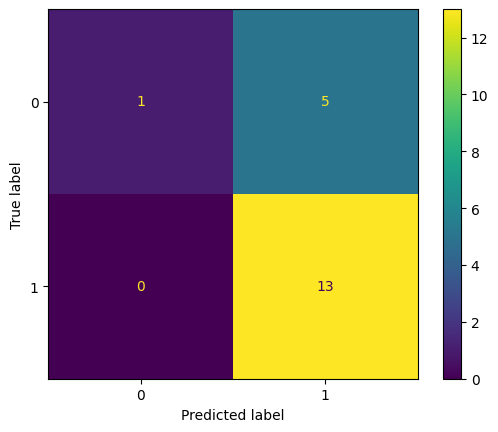

GaussianNB()

In [56]:
print('-----------------------------------------------------')

print('===> Gaussian')

classificador_hyperparametros(classificador_gauss, atributos_treino, atributos_teste, resposta_treino, resposta_teste)

#### 3.1.1 Arvore de decisão

-----------------------------------------------------
===> Tree
Fold 1 - F1 Score: 0.4886
Fold 2 - F1 Score: 0.4000
Fold 3 - F1 Score: 0.4643
Fold 4 - F1 Score: 0.4444
Fold 5 - F1 Score: 0.4400
              precision    recall  f1-score   support

         Não       1.00      0.17      0.29         6
         Sim       0.72      1.00      0.84        13

    accuracy                           0.74        19
   macro avg       0.86      0.58      0.56        19
weighted avg       0.81      0.74      0.66        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:130

{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Relatório de Classificação com DecisionTreeClassifier(): 
              precision    recall  f1-score   support

         Não       0.50      0.33      0.40         6
         Sim       0.73      0.85      0.79        13

    accuracy                           0.68        19
   macro avg       0.62      0.59      0.59        19
weighted avg       0.66      0.68      0.66        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


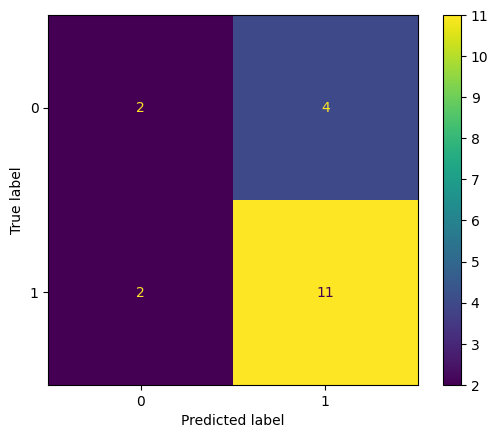

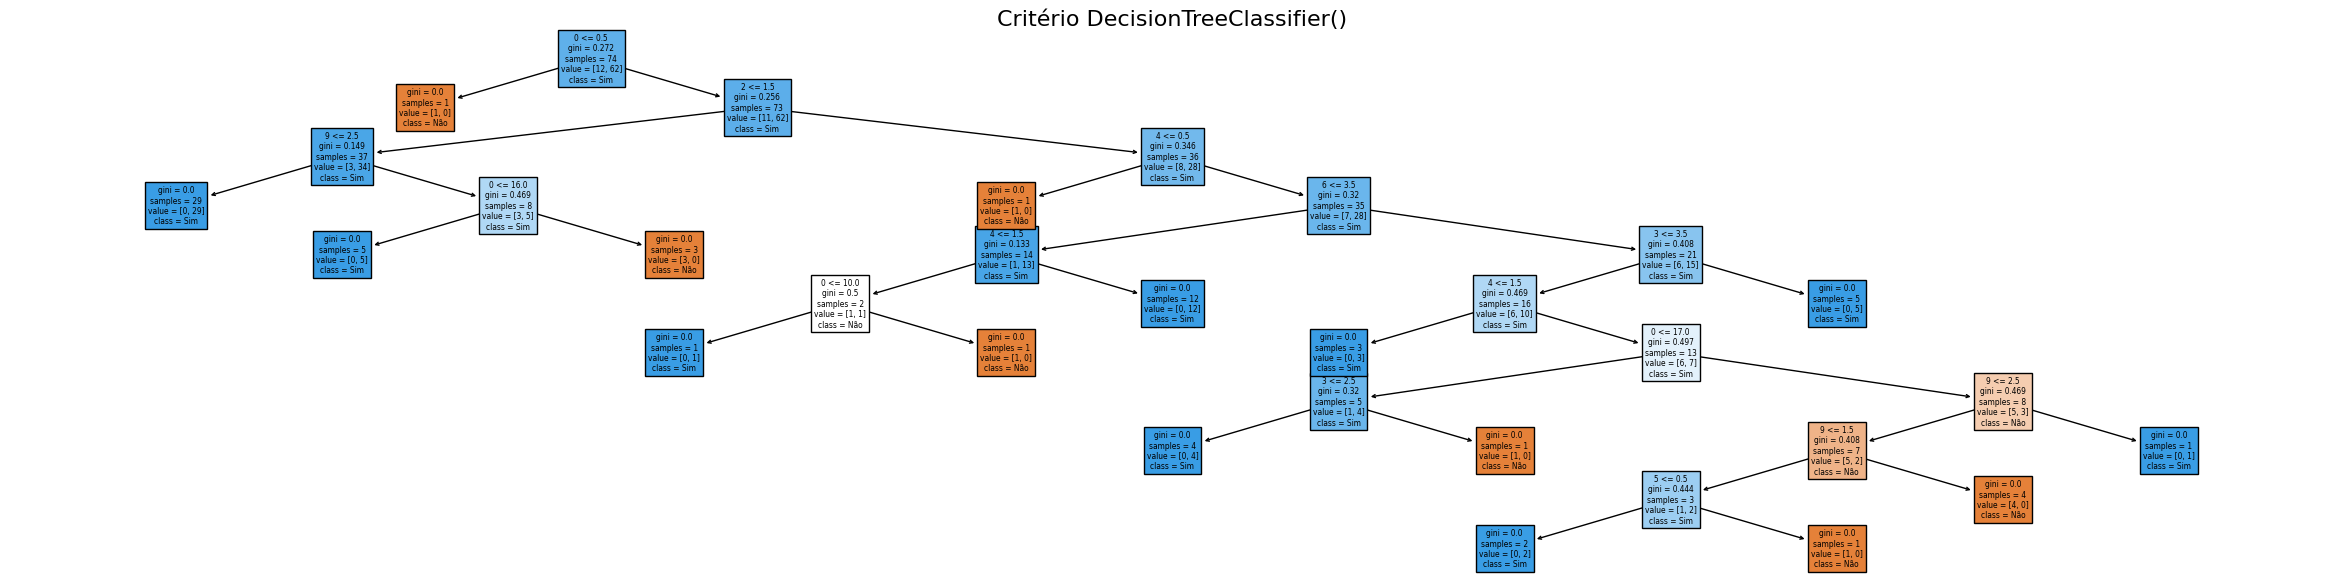

DecisionTreeClassifier()

In [57]:
print('-----------------------------------------------------')

print('===> Tree')

classificador_hyperparametros(classificador_tree, atributos_treino, atributos_teste, resposta_treino, resposta_teste) # Precisa da resposta str

#### 3.1.2 K-Neighbours

-----------------------------------------------------
===> Knn
Fold 1 - F1 Score: 0.4886
Fold 2 - F1 Score: 0.4000
Fold 3 - F1 Score: 0.4643
Fold 4 - F1 Score: 0.4444
Fold 5 - F1 Score: 0.4400
              precision    recall  f1-score   support

         Não       1.00      0.17      0.29         6
         Sim       0.72      1.00      0.84        13

    accuracy                           0.74        19
   macro avg       0.86      0.58      0.56        19
weighted avg       0.81      0.74      0.66        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:130

Relatório de Classificação com KNeighborsClassifier(metric='euclidean', n_neighbors=2): 
              precision    recall  f1-score   support

         Não       0.20      0.17      0.18         6
         Sim       0.64      0.69      0.67        13

    accuracy                           0.53        19
   macro avg       0.42      0.43      0.42        19
weighted avg       0.50      0.53      0.51        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan 

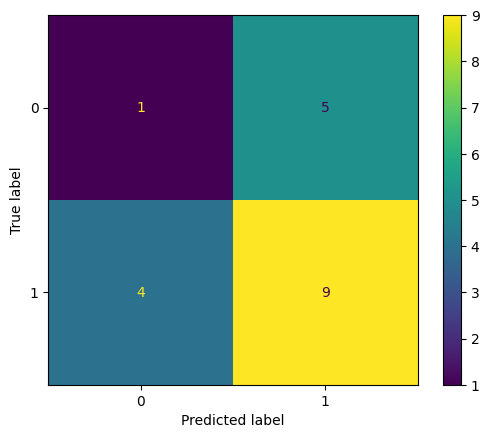

KNeighborsClassifier(metric='euclidean', n_neighbors=2)

In [58]:
print('-----------------------------------------------------')

print('===> Knn')

classificador_hyperparametros(classificador_knn, atributos_treino, atributos_teste, resposta_treino, resposta_teste)

### 3.2 Testando cada modelo com SMOTE

#### 3.0 Aplicando o SMOTE na base toda

In [59]:
smote = SMOTE(k_neighbors = 5, random_state = 0) 
atributos_smote, resposta_smote = smote.fit_resample(atributos_treino, resposta_treino)

#### 3.1.0 Usando o GaussianNB

-----------------------------------------------------
===> Gaussian com SMOTE meió
Fold 1 - F1 Score: 0.7987
Fold 2 - F1 Score: 0.8333
Fold 3 - F1 Score: 0.6377
Fold 4 - F1 Score: 0.7878
Fold 5 - F1 Score: 0.9111
              precision    recall  f1-score   support

         Não       1.00      0.33      0.50         6
         Sim       0.76      1.00      0.87        13

    accuracy                           0.79        19
   macro avg       0.88      0.67      0.68        19
weighted avg       0.84      0.79      0.75        19

Relatório de Classificação com GaussianNB(): 
              precision    recall  f1-score   support

         Não       1.00      0.33      0.50         6
         Sim       0.76      1.00      0.87        13

    accuracy                           0.79        19
   macro avg       0.88      0.67      0.68        19
weighted avg       0.84      0.79      0.75        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:130

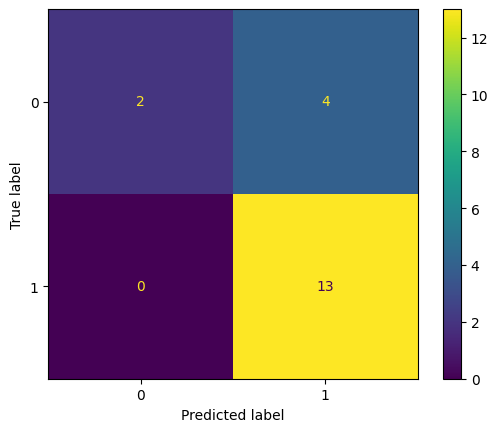

In [60]:
print('-----------------------------------------------------')

print('===> Gaussian com SMOTE meió')

model = classificador_hyperparametros(classificador_gauss, atributos_smote, atributos_teste, resposta_smote, resposta_teste)

#### 3.1.1 Arvore de decisão (meió)

-----------------------------------------------------
===> Tree Decision com SMOTE
Fold 1 - F1 Score: 0.7987
Fold 2 - F1 Score: 0.8333
Fold 3 - F1 Score: 0.6377
Fold 4 - F1 Score: 0.7878
Fold 5 - F1 Score: 0.9111
              precision    recall  f1-score   support

         Não       1.00      0.33      0.50         6
         Sim       0.76      1.00      0.87        13

    accuracy                           0.79        19
   macro avg       0.88      0.67      0.68        19
weighted avg       0.84      0.79      0.75        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:130

{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Relatório de Classificação com DecisionTreeClassifier(): 
              precision    recall  f1-score   support

         Não       0.67      0.33      0.44         6
         Sim       0.75      0.92      0.83        13

    accuracy                           0.74        19
   macro avg       0.71      0.63      0.64        19
weighted avg       0.72      0.74      0.71        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


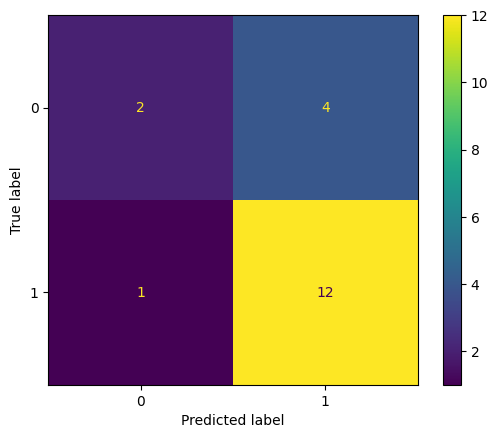

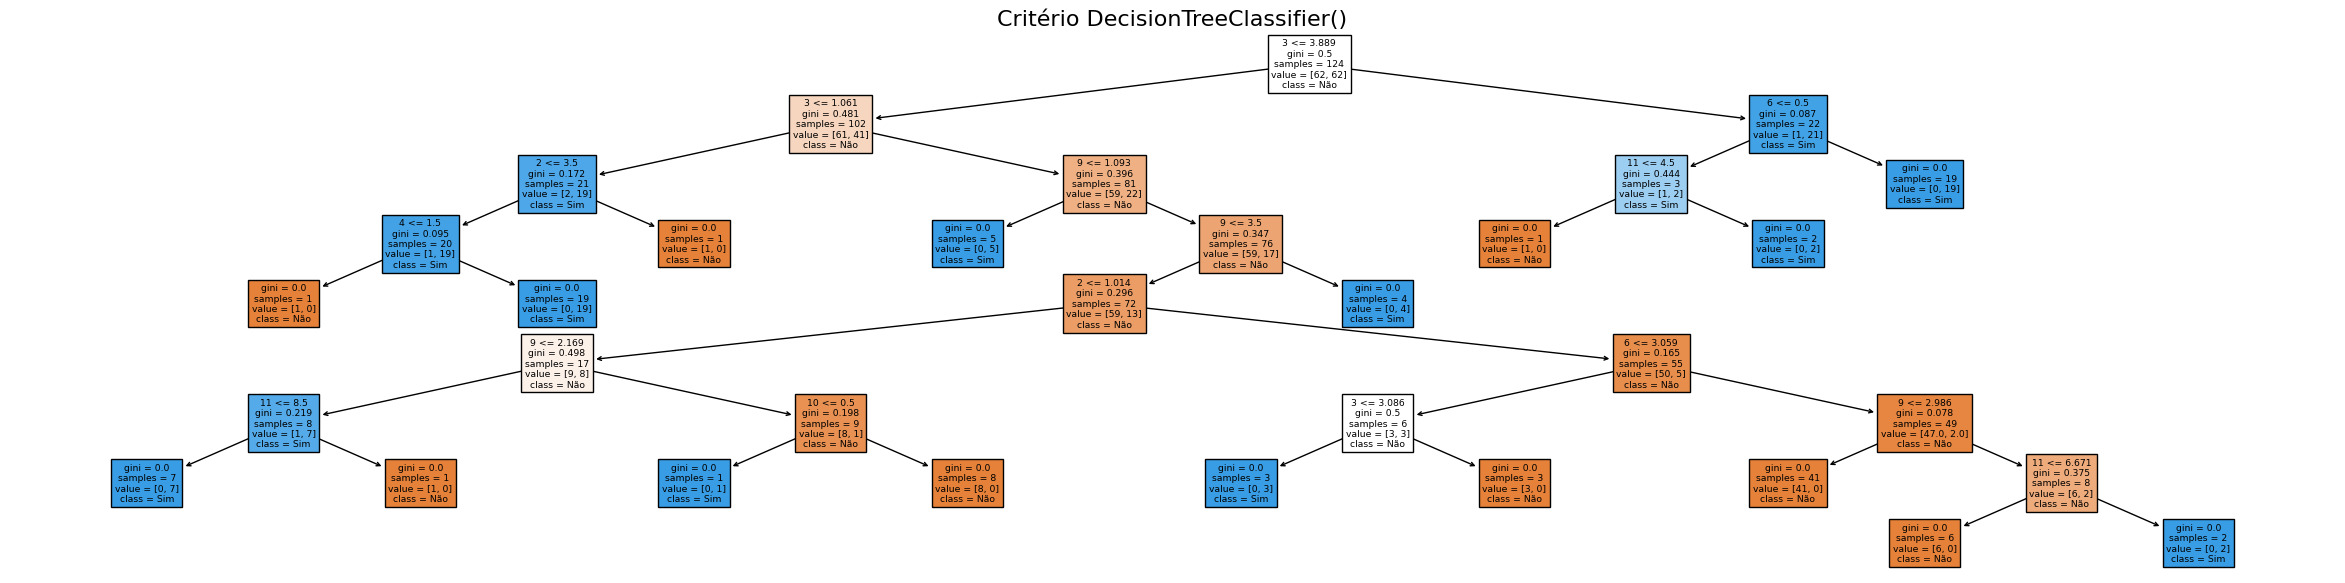

DecisionTreeClassifier()

In [61]:
print('-----------------------------------------------------')

print('===> Tree Decision com SMOTE')

classificador_hyperparametros(classificador_tree, atributos_smote, atributos_teste, resposta_smote, resposta_teste) # Precisa da resposta str

#### 3.1.2 K-Neighbours

-----------------------------------------------------
===> Knn com SMOTE
Fold 1 - F1 Score: 0.7987
Fold 2 - F1 Score: 0.8333
Fold 3 - F1 Score: 0.6377
Fold 4 - F1 Score: 0.7878
Fold 5 - F1 Score: 0.9111
              precision    recall  f1-score   support

         Não       1.00      0.33      0.50         6
         Sim       0.76      1.00      0.87        13

    accuracy                           0.79        19
   macro avg       0.88      0.67      0.68        19
weighted avg       0.84      0.79      0.75        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:130

Relatório de Classificação com KNeighborsClassifier(metric='euclidean', n_neighbors=2): 
              precision    recall  f1-score   support

         Não       0.38      0.50      0.43         6
         Sim       0.73      0.62      0.67        13

    accuracy                           0.58        19
   macro avg       0.55      0.56      0.55        19
weighted avg       0.62      0.58      0.59        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan 

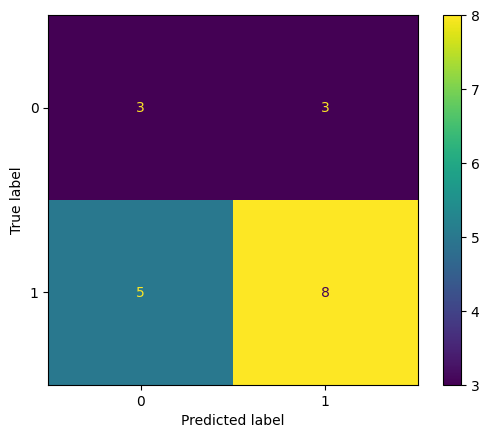

KNeighborsClassifier(metric='euclidean', n_neighbors=2)

In [62]:
print('-----------------------------------------------------')

print('===> Knn com SMOTE')

classificador_hyperparametros(classificador_knn, atributos_smote, atributos_teste, resposta_smote, resposta_teste)

### 3.3 Testando cada modelo com Random Oversampling

#### 3.0 Aplicando o Random Oversampling na base

In [63]:
random_oversample = RandomOverSampler(random_state=42)
atributos_ros, resposta_ros = random_oversample.fit_resample(atributos_treino, resposta_treino)
atributos_ros = pd.DataFrame(data=atributos_ros, columns=atributos.columns)

#### 3.1.0 Usando o GaussianNB

-----------------------------------------------------
===> Gaussian com Random Oversampling
Fold 1 - F1 Score: 0.5600
Fold 2 - F1 Score: 0.7987
Fold 3 - F1 Score: 0.5600
Fold 4 - F1 Score: 0.5192
Fold 5 - F1 Score: 0.4574
              precision    recall  f1-score   support

         Não       0.50      0.33      0.40         6
         Sim       0.73      0.85      0.79        13

    accuracy                           0.68        19
   macro avg       0.62      0.59      0.59        19
weighted avg       0.66      0.68      0.66        19

Relatório de Classificação com GaussianNB(): 
              precision    recall  f1-score   support

         Não       0.50      0.33      0.40         6
         Sim       0.73      0.85      0.79        13

    accuracy                           0.68        19
   macro avg       0.62      0.59      0.59        19
weighted avg       0.66      0.68      0.66        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:130

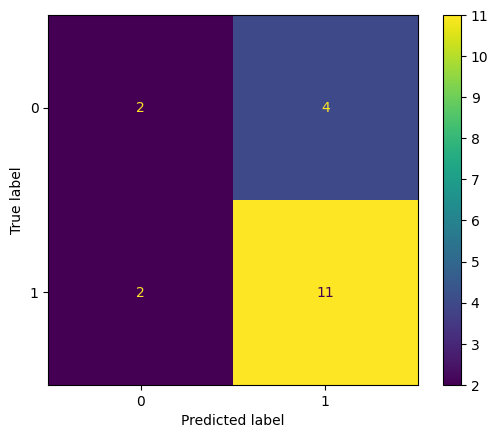

GaussianNB()

In [64]:
print('-----------------------------------------------------')

print('===> Gaussian com Random Oversampling')

classificador_hyperparametros(classificador_gauss, atributos_ros, atributos_teste, resposta_ros, resposta_teste)

#### 3.1.1 Arvore de decisão

-----------------------------------------------------
===> Tree Decision com Random Oversampling
Fold 1 - F1 Score: 0.5600
Fold 2 - F1 Score: 0.7987
Fold 3 - F1 Score: 0.5600
Fold 4 - F1 Score: 0.5192
Fold 5 - F1 Score: 0.4574
              precision    recall  f1-score   support

         Não       0.50      0.33      0.40         6
         Sim       0.73      0.85      0.79        13

    accuracy                           0.68        19
   macro avg       0.62      0.59      0.59        19
weighted avg       0.66      0.68      0.66        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:130

{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Relatório de Classificação com DecisionTreeClassifier(): 
              precision    recall  f1-score   support

         Não       0.67      0.67      0.67         6
         Sim       0.85      0.85      0.85        13

    accuracy                           0.79        19
   macro avg       0.76      0.76      0.76        19
weighted avg       0.79      0.79      0.79        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


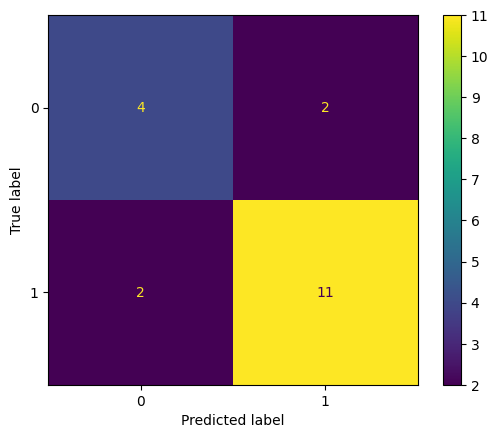

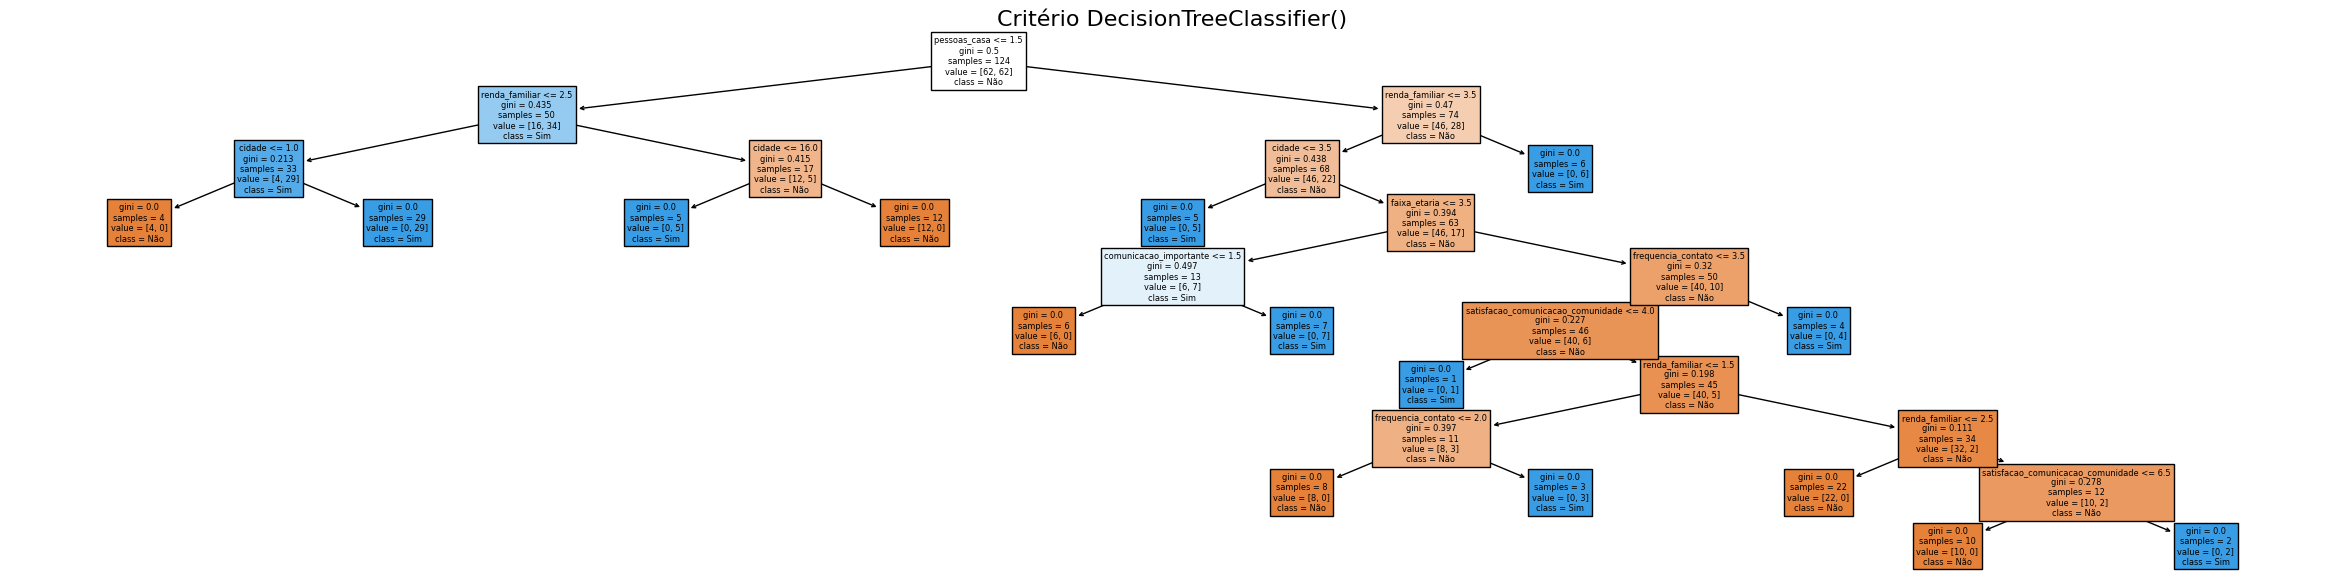

DecisionTreeClassifier()

In [65]:
print('-----------------------------------------------------')

print('===> Tree Decision com Random Oversampling')

classificador_hyperparametros(classificador_tree, atributos_ros, atributos_teste, resposta_ros, resposta_teste) # Precisa da resposta str

# plotar_matriz_conf(resposta_ros)

#### 3.1.2 K-Neighbours

-----------------------------------------------------
===> Knn com Random Oversampling
Fold 1 - F1 Score: 0.5600
Fold 2 - F1 Score: 0.7987
Fold 3 - F1 Score: 0.5600
Fold 4 - F1 Score: 0.5192
Fold 5 - F1 Score: 0.4574
              precision    recall  f1-score   support

         Não       0.50      0.33      0.40         6
         Sim       0.73      0.85      0.79        13

    accuracy                           0.68        19
   macro avg       0.62      0.59      0.59        19
weighted avg       0.66      0.68      0.66        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:130

Relatório de Classificação com KNeighborsClassifier(metric='euclidean', n_neighbors=2): 
              precision    recall  f1-score   support

         Não       0.20      0.17      0.18         6
         Sim       0.64      0.69      0.67        13

    accuracy                           0.53        19
   macro avg       0.42      0.43      0.42        19
weighted avg       0.50      0.53      0.51        19



C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan 

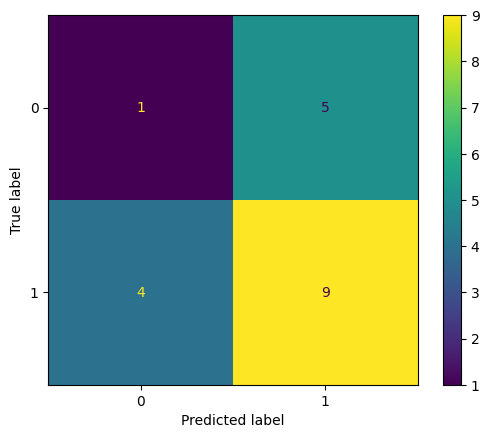

KNeighborsClassifier(metric='euclidean', n_neighbors=2)

In [66]:
print('-----------------------------------------------------')

print('===> Knn com Random Oversampling')

classificador_hyperparametros(classificador_knn, atributos_ros, atributos_teste, resposta_ros, resposta_teste )

## 4. Serialização

In [67]:
print(model)

GaussianNB()


In [68]:
pipeline = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('model', model)
])

# Definir o caminho do arquivo de saída
output_dir = os.path.join(os.getcwd(), '/flask/')  # Ajuste para o diretório desejado

# Verifique se a pasta existe; se não, crie-a
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Caminho completo do arquivo
model_path = os.path.join(output_dir, 'pipeline.pkl')

# Salvar o pipeline
with open(model_path, 'wb') as arquivo:
    joblib.dump(pipeline, arquivo)

In [69]:
# def deserialização(new_row):
#     with open('modelo.pkl', 'rb') as f:
#         loaded_model = pickle.load(f)
    
#     with open('preprocessador.pkl', 'rb') as f:
#         preprocessador_model = pickle.load(f)

#     new_row_df = pd.DataFrame([new_row], columns=['compra','manutencao','portas','pessoas','porta-malas','seguranca'])
    
#     try:
#         transformed_array = preprocessador_model.transform(new_row_df)
    
#         new_row_transformed = pd.DataFrame(transformed_array)
#         print("Linha transformada")
    
#     except Exception as e:
#         print(f"Erro durante a transformação: {e}")

#     resp = loaded_model.predict(new_row_transformed)

#     print('Resultado: ', resp)

In [70]:
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', RandomForestClassifier())
# ])

# param_grid = {
#     'classifier__n_estimators': [50, 100, 200],
#     'classifier__max_depth': [None, 10, 20, 30]
# }

# grid_search = GridSearchCV(pipeline, param_grid, cv=5)
# grid_search.fit(atributos_treino, resposta_treino)

In [71]:
# # Import Joblib
# import joblib

# # Save the model to a file
# joblib.dump(grid_search, 'model.joblib')

# loaded_model_joblib = joblib.load('model.joblib')

## 5. Conclusão Geral

In [72]:
df_olimpo

,cidade,tipo_moradia,pessoas_casa,satisfacao_comunicacao_comunidade,frequencia_contato,comunicacao_importante,usa_plataforma,faixa_etaria,qualidade_vida,situacao_trabalho,renda_familiar,animais,implementa_app
0,São Paulo,Apartamento,1,7,Raramente,Sim,Não,Maior ou igual a 43 anos,Boa,Empregado,Classe C,Não,Sim
1,São Paulo,Apartamento,1,2,Raramente,Não,Não,Menor ou igual a 17 anos,Boa,Empregado,Classe B,Sim,Sim
2,Osasco,Apartamento,Nenhuma,3,Ocasionalmente,Sim,Não,Maior ou igual a 43 anos,Boa,Empregado,Classe C,Sim,Sim
3,São Paulo,Apartamento,3,5,Ocasionalmente,Sim,Não,Menor ou igual a 17 anos,Boa,Empregado,Classe B,Sim,Sim
4,São Paulo,Casa,3,7,Nunca,Sim,Não,Menor ou igual a 17 anos,Ótima,Empregado,Classe C,Não,Não
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,São Paulo,Apartamento,2,8,Frequentemente,Sim,Não,Menor ou igual a 17 anos,Boa,Empregado,Classe C,Não,Sim
89,São Paulo,Casa,2,8,Raramente,Não sei,Não,Menor ou igual a 17 anos,Boa,Empregado,Classe B,Sim,Sim
90,Caieiras,Casa,3,3,Diariamente,Sim,Não,Maior ou igual a 43 anos,Ruim,Empregado,Classe C,Sim,Sim
91,Caieiras,Casa,2,8,Frequentemente,Sim,Não,Maior ou igual a 43 anos,Ótima,Empregado,Classe C,Sim,Sim
